In [6]:
import torch
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

# Make Python aware of the library by expanding the path search
import sys
sys.path.append("..")
from adv_gen.generator import AdversarialExampleGenerator

In [7]:
model = models.resnet34(weights=models.ResNet34_Weights)
model.eval(); # Set the model to inference mode (to deactivate dropout, etc.)

In [8]:
def get_classes_names() -> dict[int, str]:
    """Returns a dictionary mapping class indices to class names."""
    with open("imagenet_classes.txt") as f:
        # Just keep the first word of every class description
        classes = [line.strip().split(',')[0] for line in f.readlines()]
    return dict(enumerate(classes))

In [9]:
def image_to_tensor(img: Image.Image) -> torch.Tensor:
    transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Add the batch dimension
    # （C, H, W) --> (1, C, H, W)
    return transform(img).unsqueeze(0)

def tensor_to_image(tensor: torch.Tensor) -> Image.Image:
    transform = transforms.Compose(
        [
            # De-normalize
            transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        ]
    )

    # Remove the batch dimension
    # (1, C, H, W) --> (C, H, W)
    image = transform(tensor.squeeze(0))
    image = image.clamp(0, 1)
    # (C, H, W) --> (H, W, C)
    image = image.permute(1, 2, 0)
    return image.detach().numpy()


def get_input_tensor(img_path: str) -> torch.Tensor:
    img = Image.open(img_path)
    # Applies normalization and scaling. Returns a tensor of shape (C, H, W)
    img_tensor = image_to_tensor(img)
    img_tensor.requires_grad = True
    return img_tensor


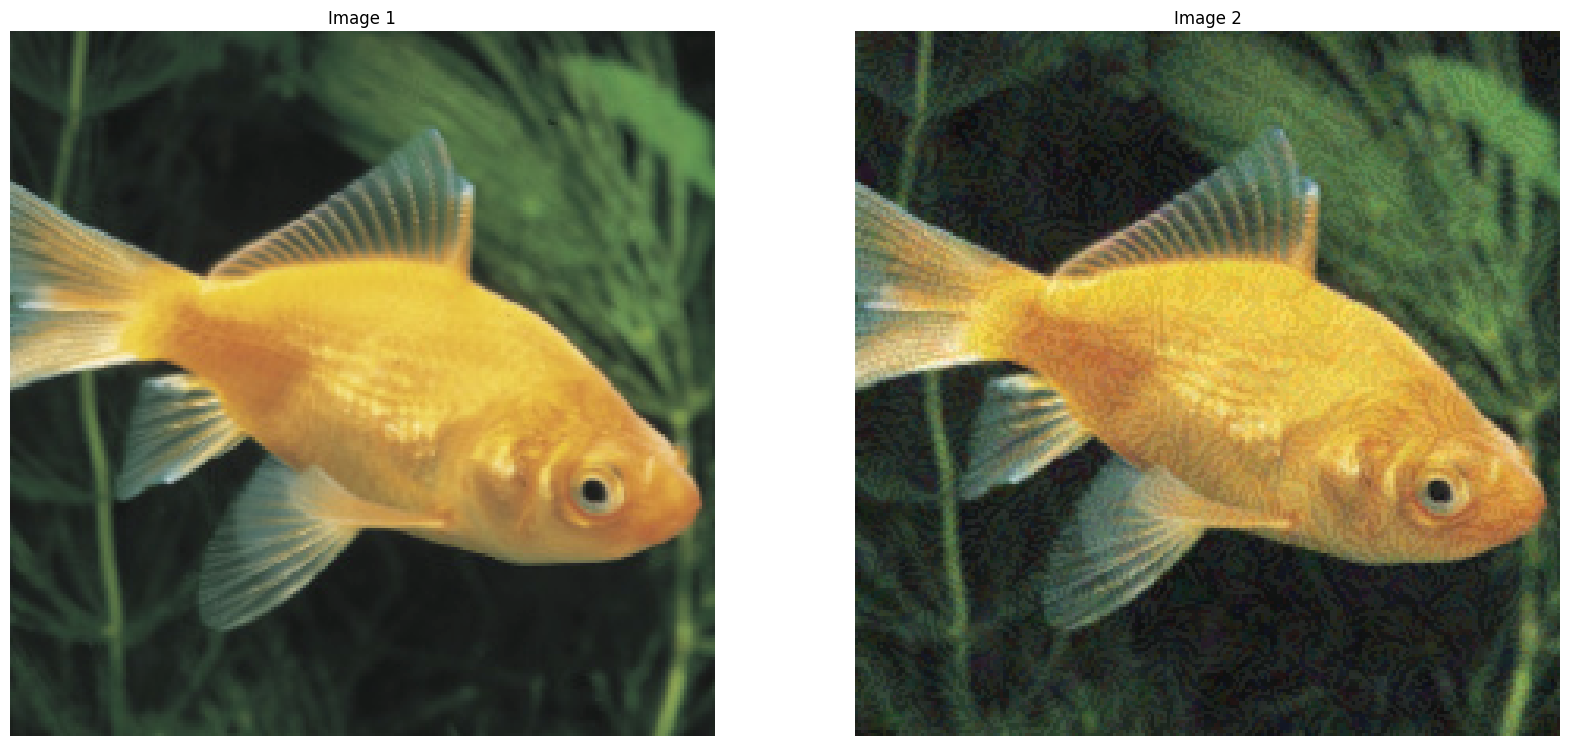

Desired target class: vizsla
Original image predicted class: goldfish
Adversarial image predicted class: vizsla
Original image predicted class probability: 0.991932213306427
Adversarial image predicted class probability: 0.9128407835960388


In [10]:
def show_images(imgs: list[Image.Image]) -> None:
    # Create a figure to display the images
    fig = plt.figure(figsize=(20, 20))
    # Get the number of images
    num_images = len(imgs)
    # Loop through the images and add them to the figure
    for i in range(num_images):
        # Add a subplot for each image
        ax = fig.add_subplot(1, num_images, i + 1)
        # Get the image at the current index
        img = imgs[i]
        # Show the image on the subplot
        ax.imshow(img)
        # Hide the axes
        ax.axis("off")
        # Add the title
        ax.set_title(f"Image {i + 1}")
    
    plt.show()

generator = AdversarialExampleGenerator(model)

original_example = get_input_tensor('goldfish.jpeg')
target_class = random.randint(0, 999)
adversarial_example = generator.generate(original_example, target_class, num_steps=5)

original_output = model(original_example)
adversarial_output = model(adversarial_example)

show_images([tensor_to_image(original_example), tensor_to_image(adversarial_example)])

predicted_class_original = torch.max(original_output.data, 1)[1][0]
predicted_class_adversarial = torch.max(adversarial_output.data, 1)[1][0]

classes_names = get_classes_names()

print(f'Desired target class: {classes_names[target_class]}')

print("Original image predicted class: {}".format(classes_names[predicted_class_original.item()]))
print("Adversarial image predicted class: {}".format(classes_names[predicted_class_adversarial.item()]))

print("Original image predicted class probability: {}".format(torch.max(F.softmax(original_output.data, dim=1)[0])))
print("Adversarial image predicted class probability: {}".format(torch.max(F.softmax(adversarial_output.data, dim=1)[0])))